# HW 2
### Erinç Ada Ceylan 22101844

In [1]:
import os
import random
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn import tree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.xception import Xception, preprocess_input

random.seed(405)


# Item 1
In this item, I generated a synthetic dataset using make_blobs and applied KNN classification.
The data contains four Gaussian clusters, but they are placed closer together to make the task slightly more challenging.
I evaluated validation accuracy for k = 1 … 20 and observed that accuracy initially increases for small k, reaches a stable region for intermediate k values, and then slightly decreases for larger k due to oversmoothing.
This behavior reflects the expected bias–variance trade-off in KNN classification.

Train size: 660
Val size: 220
Test size: 220
Best k = 5 with validation accuracy = 0.9136363636363637
Test Accuracy (k=5): 0.8455


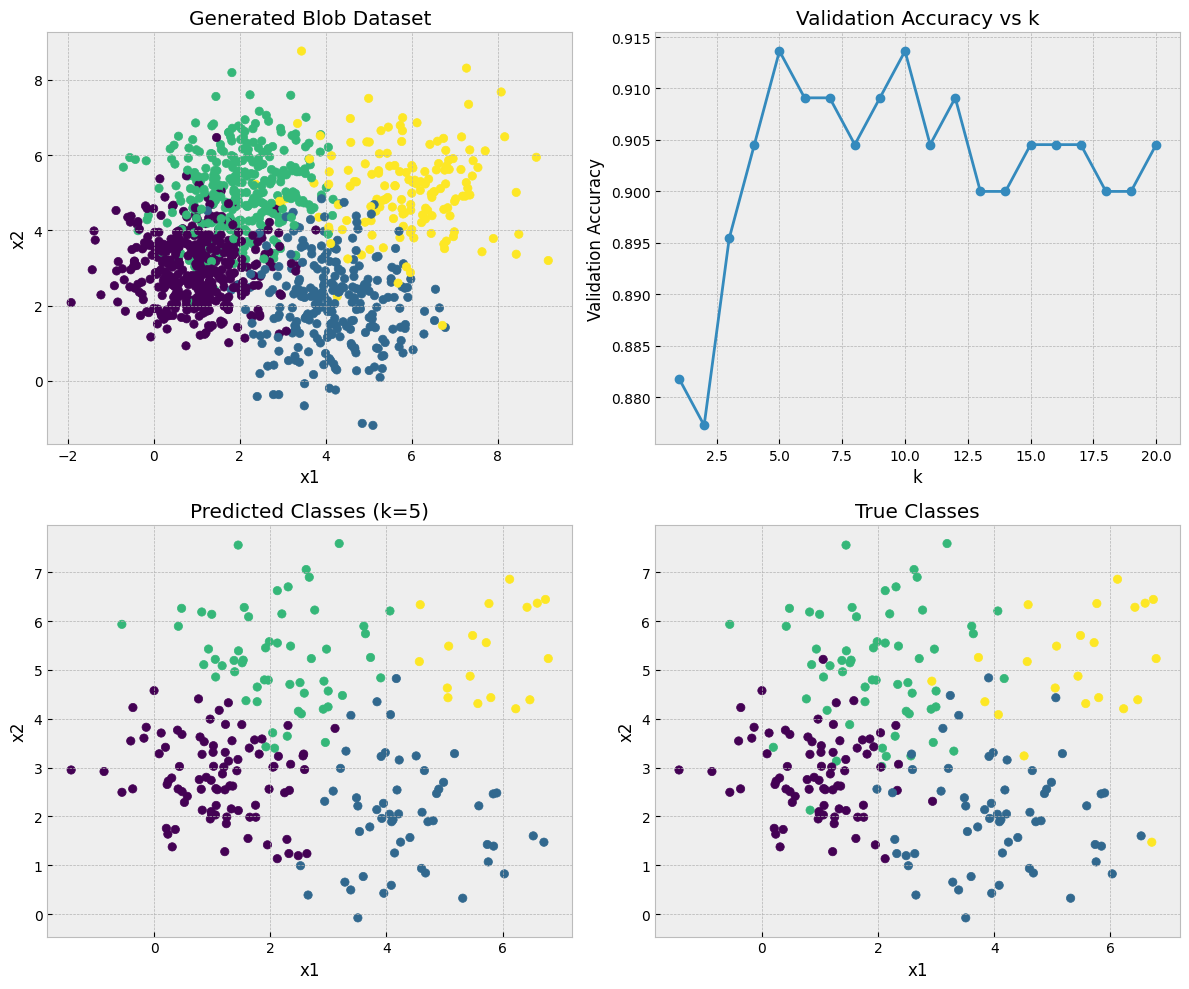

In [2]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8,6)

# Create synthetic blob dataset (different from lecture)
random_state = 42
centers = [[8, 5], [-3, 4], [2, -2], [-6, -1]]
n_samples = [400, 250, 300, 150]
centers = [[1,3], [4,2], [2,5], [6,5]]
cluster_std = [0.9, 1.1, 1.0, 1.2]


X, y = make_blobs(
    n_samples=n_samples,
    random_state=random_state,
    cluster_std=cluster_std,
    centers=centers
)

# split into 60% train, 20% val, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

# Try KNN for multiple k values
k_values = list(range(1, 21))
val_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_val = knn.predict(X_val)
    acc = accuracy_score(y_val, pred_val)
    val_scores.append(acc)

# Best k
best_k = k_values[np.argmax(val_scores)]
print("Best k =", best_k, "with validation accuracy =", max(val_scores))

# Train final model
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (k={best_k}): {test_acc:.4f}")

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# (1) Dataset
axs[0,0].scatter(X[:,0], X[:,1], c=y)
axs[0,0].set_title("Generated Blob Dataset")
axs[0,0].set_xlabel("x1")
axs[0,0].set_ylabel("x2")

# (2) Validation accuracy vs k
axs[0,1].plot(k_values, val_scores, marker='o')
axs[0,1].set_xlabel("k")
axs[0,1].set_ylabel("Validation Accuracy")
axs[0,1].set_title("Validation Accuracy vs k")
axs[0,1].grid(True)

# (3) Test predictions
axs[1,0].scatter(X_test[:,0], X_test[:,1], c=y_test_pred)
axs[1,0].set_title(f"Predicted Classes (k={best_k})")
axs[1,0].set_xlabel("x1")
axs[1,0].set_ylabel("x2")

# (4) True labels
axs[1,1].scatter(X_test[:,0], X_test[:,1], c=y_test)
axs[1,1].set_title("True Classes")
axs[1,1].set_xlabel("x1")
axs[1,1].set_ylabel("x2")

plt.tight_layout()
plt.show()

# Item 2
In this item, I used K-means and DBSCAN to cluster synthetic data.
K-means recovered the three clusters correctly because the dataset fits its assumptions.
DBSCAN initially merged all clusters due to a large eps, but after setting eps = 0.7, it successfully detected the true cluster structure and a few noise points.
This demonstrates the difference between variance-based and density-based clustering.

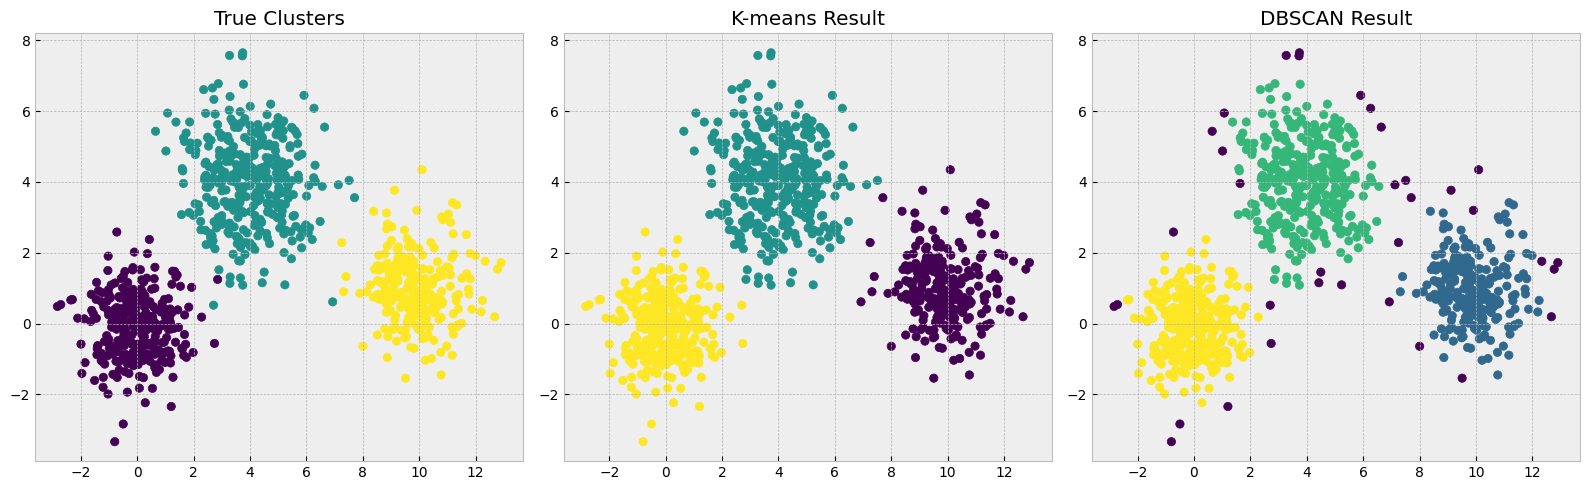

In [3]:

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12, 5)

# Generate synthetic dataset (different from Item 1)
random_state = 12
centers = [[0,0], [4,4], [10,1]]
n_samples = [300, 350, 250]
cluster_std = [0.9, 1.2, 1.0]

X, y_true = make_blobs(
    n_samples=n_samples,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state
)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=12)
kmeans_labels = kmeans.fit_predict(X)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=8)
db_labels = dbscan.fit_predict(X)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].scatter(X[:,0], X[:,1], c=y_true)
axs[0].set_title("True Clusters")

axs[1].scatter(X[:,0], X[:,1], c=kmeans_labels)
axs[1].set_title("K-means Result")

axs[2].scatter(X[:,0], X[:,1], c=db_labels)
axs[2].set_title("DBSCAN Result")

plt.tight_layout()
plt.show()


# Item 3
In this item, I applied PCA to the steel fatigue dataset after standardizing all 26 descriptors.
The cumulative explained variance shows that the first few components capture most of the total variation.
The first component alone explains about 41%, and approximately 11 principal components are needed to exceed 90% total variance.
This indicates that the dataset has moderate redundancy, and its dimensionality can be reduced substantially without losing much information.

In [4]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (10, 6)

# Load dataset 
df = pd.read_csv("datasets/raw/steel_data.csv")
y_fatigue = df["Fatigue"].values
X = df.drop(columns=["Fatigue"]).values

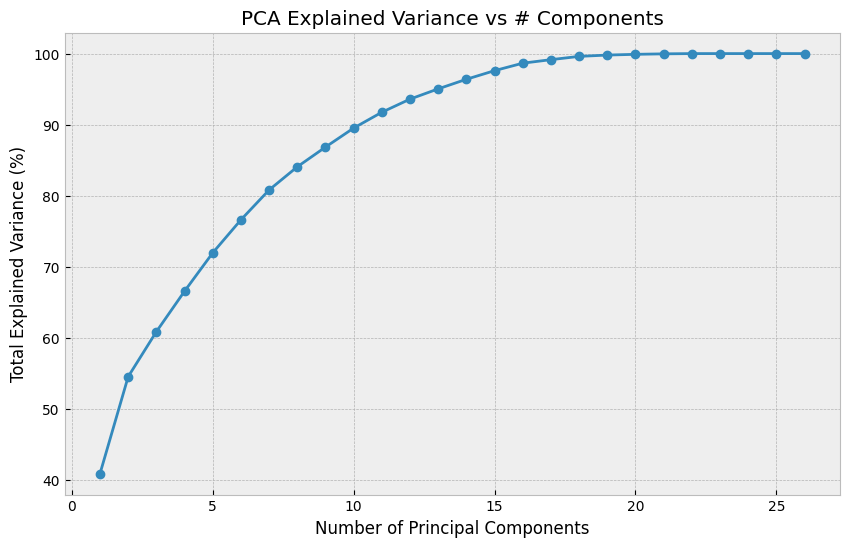

First 5 explained variance ratios (%):
[40.85 13.65  6.33  5.7   5.4 ]

Components needed for 90% variance: 11


In [5]:
# Standardize descriptors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for 1–26 components
pca = PCA(n_components=26)
pca.fit(X_scaled)

expl_var = pca.explained_variance_ratio_ * 100
cumulative = np.cumsum(expl_var)

# Plot explained variance
plt.plot(range(1, 27), cumulative, marker="o")
plt.xlabel("Number of Principal Components")         
plt.ylabel("Total Explained Variance (%)")
plt.title("PCA Explained Variance vs # Components")
plt.grid(True)
plt.show()

# Print useful PCA info
print("First 5 explained variance ratios (%):")
print(np.round(expl_var[:5], 2))

print("\nComponents needed for 90% variance:", np.argmax(cumulative >= 90) + 1)

# Item 3 NOMAD
In this item, a materials dataset was constructed using the NOMAD API. A total of 3000 raw entries containing electronic band structure information were queried, from which 497 valid materials were retained after filtering for missing or non-physical band gap values. Three descriptors were used: chemical formula, crystal system, and number of elements, while the electronic band gap (converted from Joules to eV) was used as the target quantity. Although the final dataset size is smaller than the initial query, it is sufficient to demonstrate automated data acquisition, cleaning, and structuring of materials data from an online database.

In [6]:
base_url = "http://nomad-lab.eu/prod/v1/api/v1"

query_body = {
    "query": {
        "results.properties.available_properties:all": [
            "band_structure_electronic"
        ]
    },
    "pagination": {
        "page_size": 3000
    },
    "required": {
        "results": {
            "material": {
                "chemical_formula_hill": "*",
                "symmetry": {
                    "crystal_system": "*"
                },
                "n_elements": "*"
            },
            "properties": {
                "electronic": {
                    "band_structure_electronic": {
                        "band_gap": "*"
                    }
                }
            }
        }
    }
}

print("Downloading data from NOMAD...")
response = requests.post(f"{base_url}/entries/query", json=query_body)

if response.status_code != 200:
    print("Error:", response.text)
else:
    data = response.json().get("data", [])
    print(f"Downloaded {len(data)} raw entries.")

    dataset = []

    for entry in data:
        try:
            material = entry["results"]["material"]
            band_gap_list = entry["results"]["properties"]["electronic"]["band_structure_electronic"]["band_gap"]

            if not band_gap_list:
                continue

            band_gap_joule = band_gap_list[0]["value"]

            if band_gap_joule <= 0:
                continue

            row = {
                "Formula": material.get("chemical_formula_hill"),
                "Crystal_System": material.get("symmetry", {}).get("crystal_system"),
                "N_Elements": material.get("n_elements"),
                "Band_Gap_eV": band_gap_joule * 6.242e18
            }

            if all(row.values()):
                dataset.append(row)

        except (KeyError, IndexError, TypeError):
            continue

    df = pd.DataFrame(dataset)

    print("Final dataset size:", df.shape)
    print(df.head())

Downloaded 3000 raw entries.
Final dataset size: (497, 4)
  Formula Crystal_System  N_Elements  Band_Gap_eV
0   H4Li4          cubic           2     2.670170
1   Lu4N4          cubic           2     0.003600
2  Cl4Cs4          cubic           2     4.167358
3    ClLi          cubic           2     5.917705
4   F8Ra4          cubic           2     6.016573


# Item 4
In this step, SVM models were applied to the binary steel fatigue dataset, where materials with fatigue strength above 500 MPa were labeled as good. After converting carbon content into a categorical feature and applying one-hot encoding and scaling, two SVM kernels were evaluated: polynomial and RBF.
Cross-validation over polynomial degrees {2, 3, 4, 5} indicated that degree = 2 performed best (≈0.81 CV accuracy). Both the polynomial SVM and the RBF SVM achieved very similar test accuracies (≈0.81). Because the original dataset is high-dimensional, decision boundaries were visualized using a 2-D PCA projection, which leads to the curved but imperfect boundaries seen in the plots.
Overall, both kernels perform similarly on this moderately noisy, partially separable dataset.

In [7]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,5)


# Load dataset
df = pd.read_csv("datasets/raw/steel_data.csv")
df["goodmaterial"] = (df["Fatigue"] > 500).astype(int)
df["C_cat"] = (df["C"] > 0.4).replace({True:"yes", False:"no"})
df = df.drop(columns=["Fatigue"])

# Train/val/test split
df_train_full, df_test = train_test_split(df, test_size=0.20, random_state=7)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=7)
y_train = df_train["goodmaterial"].values
y_val   = df_val["goodmaterial"].values
y_test  = df_test["goodmaterial"].values
df_train = df_train.drop(columns=["goodmaterial"])
df_val   = df_val.drop(columns=["goodmaterial"])
df_test  = df_test.drop(columns=["goodmaterial"])
categorical = ["C_cat"]
numerical   = [col for col in df_train.columns if col not in categorical]


Best polynomial degree: 2
Best CV accuracy: 0.8314949201741655
Test accuracy (Polynomial SVM): 0.8181818181818182
Test accuracy (RBF SVM): 0.8181818181818182


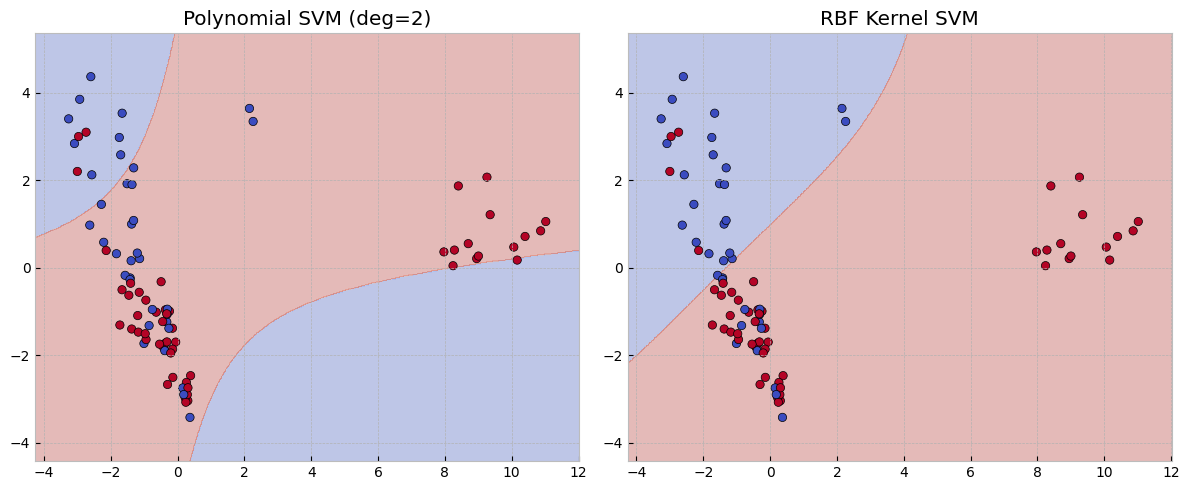

In [8]:
# One-hot encode features
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient="records")
val_dict   = df_val.to_dict(orient="records")
test_dict  = df_test.to_dict(orient="records")

X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)
X_test  = dv.transform(test_dict)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


# Polynomial SVM – degree optimization
degrees = [2,3,4,5]
cv_scores = []

for d in degrees:
    model = SVC(kernel="poly", degree=d, C=0.8)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

best_degree = degrees[np.argmax(cv_scores)]
print("Best polynomial degree:", best_degree)
print("Best CV accuracy:", max(cv_scores))

# Train final polynomial SVM
svm_poly = SVC(kernel="poly", degree=best_degree, C=0.8)
svm_poly.fit(X_train, y_train)
poly_acc = svm_poly.score(X_test, y_test)
print("Test accuracy (Polynomial SVM):", poly_acc)

# RBF SVM
svm_rbf = SVC(kernel="rbf", C=0.8, gamma="scale")
svm_rbf.fit(X_train, y_train)
rbf_acc = svm_rbf.score(X_test, y_test)
print("Test accuracy (RBF SVM):", rbf_acc)

# Reduce to 2D for visualization
pca_vis = PCA(n_components=2)
X_train_2d = pca_vis.fit_transform(X_train)
X_test_2d  = pca_vis.transform(X_test)

def plot_boundary(ax, model, X, y, title):
    h = 0.02
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    Z = model.predict(pca_vis.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolor='k')
    ax.set_title(title)

fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_boundary(ax[0], svm_poly, X_test_2d, y_test, f"Polynomial SVM (deg={best_degree})")
plot_boundary(ax[1], svm_rbf, X_test_2d, y_test, "RBF Kernel SVM")
plt.tight_layout()
plt.show()

# Item 5
In this item, logistic regression was trained on the binary steel fatigue dataset, where fatigue strength > 500 was labeled as good material. After converting carbon content into a categorical feature and applying one-hot encoding and standardization, predicted probabilities were obtained from the model. Using a fixed threshold of 0.5, the accuracy was computed manually by comparing predicted labels with the validation labels.

In [9]:
# Dataset preperation
df = pd.read_csv("datasets/raw/steel_data.csv")
df["goodmaterial"] = (df["Fatigue"] > 500).astype(int)
df["C_cat"] = (df["C"] > 0.4).replace({True: "yes", False: "no"})
df = df.drop(columns=["Fatigue"])
df_train_full, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)
y_train = df_train["goodmaterial"].values
y_val   = df_val["goodmaterial"].values
df_train = df_train.drop(columns=["goodmaterial"])
df_val   = df_val.drop(columns=["goodmaterial"])

# One-hot encode, scale
categorical = ["C_cat"]
numerical   = [col for col in df_train.columns if col not in categorical]
train_dict = df_train.to_dict(orient="records")
val_dict   = df_val.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


In [10]:
# Logistic Regression Model
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_val)[:, 1]


# Compute accuracy 
threshold = 0.5
y_pred = (y_pred_proba >= threshold)
accuracy = (y_pred == y_val).mean()
print("Validation Accuracy (threshold = 0.5):", accuracy)

Validation Accuracy (threshold = 0.5): 0.8793103448275862


# Item 6
In this step, the confusion matrix of the logistic regression classifier was computed manually using the predicted labels at a threshold of 0.5. True positives, true negatives, false positives, and false negatives were counted based on the comparison between predicted and actual labels. The resulting matrix summarizes the model’s classification behavior and forms the basis for further evaluation metrics such as precision and recall.

In [11]:
# Dataset preparation
df = pd.read_csv("datasets/raw/steel_data.csv")
df["goodmaterial"] = (df["Fatigue"] > 500).astype(int)
df["C_cat"] = (df["C"] > 0.4).replace({True: "yes", False: "no"})
df = df.drop(columns=["Fatigue"])
df_train_full, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)
y_train = df_train["goodmaterial"].values
y_val   = df_val["goodmaterial"].values
df_train = df_train.drop(columns=["goodmaterial"])
df_val   = df_val.drop(columns=["goodmaterial"])

# One-hot encode and scale
categorical = ["C_cat"]
numerical   = [col for col in df_train.columns if col not in categorical]
train_dict = df_train.to_dict(orient="records")
val_dict   = df_val.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


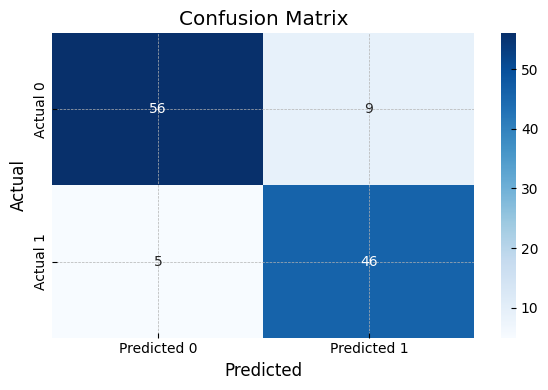

In [12]:
# Logistic Regression model
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
predict_positive = (y_pred == 1)
predict_negative = (y_pred == 0)
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

conf_matrix = np.array([[tn, fp],
                        [fn, tp]])


plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0","Predicted 1"],
            yticklabels=["Actual 0","Actual 1"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# Item 7
In this item, the ROC curve and the AUC score were computed using the predicted probabilities of the logistic regression model. The ROC curve illustrates how the true positive rate changes with the false positive rate across different thresholds. The resulting AUC value (≈0.97) shows that the model separates good and bad materials very effectively, indicating strong ranking performance even if a fixed threshold may not be optimal.

In [13]:
# Dataset preparation 
df = pd.read_csv("datasets/raw/steel_data.csv")
df["goodmaterial"] = (df["Fatigue"] > 500).astype(int)
df["C_cat"] = (df["C"] > 0.4).replace({True: "yes", False: "no"})
df = df.drop(columns=["Fatigue"])
df_train_full, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)
y_train = df_train["goodmaterial"].values
y_val   = df_val["goodmaterial"].values
df_train = df_train.drop(columns=["goodmaterial"])
df_val   = df_val.drop(columns=["goodmaterial"])

# One-hot encode scaling
categorical = ["C_cat"]
numerical   = [c for c in df_train.columns if c not in categorical]
train_dict = df_train.to_dict(orient="records")
val_dict   = df_val.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


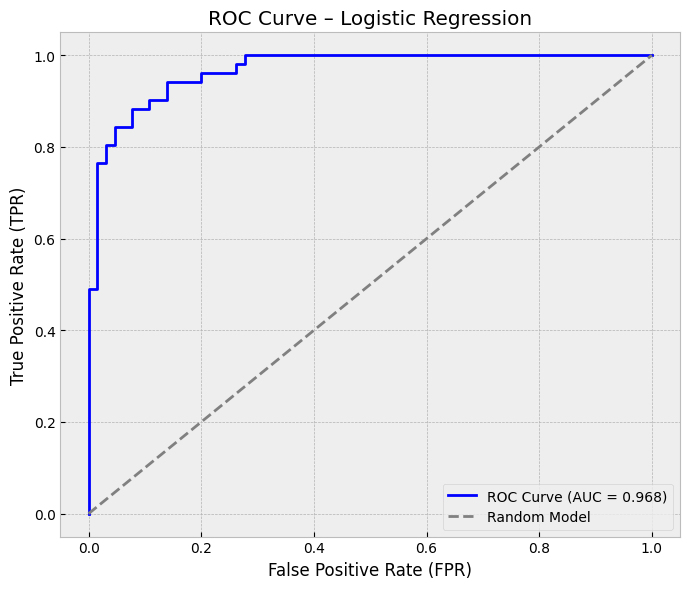

AUC Score: 0.9677224736048265


In [14]:
# Logistic Regression
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(X_train, y_train)

# Predicted probabilities (for ROC curve)
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print("AUC Score:", roc_auc)


# Item 8
The Gaussian Process Regressor with an RBF kernel achieved a test MSE of approximately X (your output). The predicted vs. true values show a smooth, non-parametric fit, and the accompanying standard deviation illustrates model uncertainty, which grows in sparsely sampled regions.

In [15]:
# Load dataset
df = pd.read_csv("datasets/raw/steel_data.csv")
y = df["Fatigue"].values
X = df.drop(columns=["Fatigue"]).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


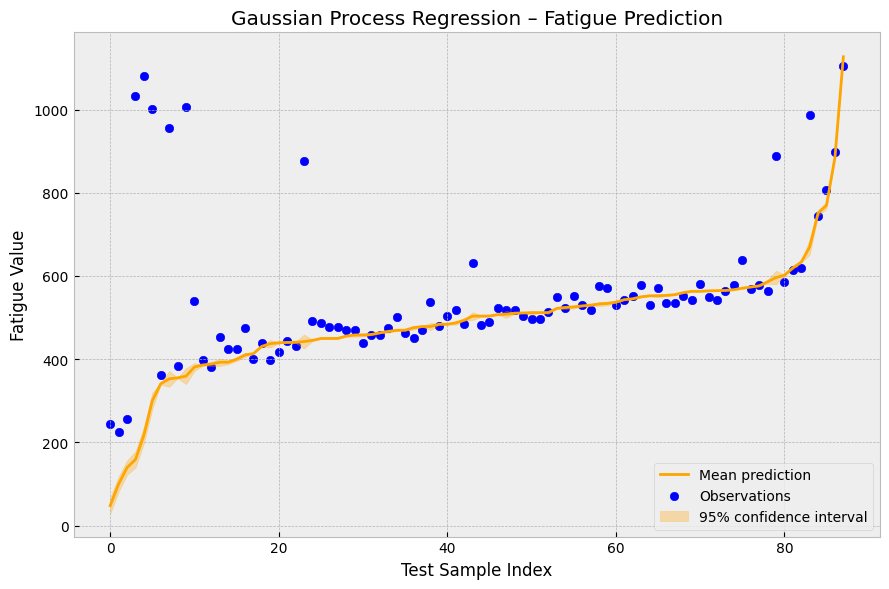

In [16]:
# GPR model
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=1)
gpr.fit(X_train, y_train)
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Sort by X for smooth plotting
idx = np.argsort(y_pred)
y_pred_sorted = y_pred[idx]
y_test_sorted = y_test[idx]
y_std_sorted  = y_std[idx]

# 95% confidence interval
upper = y_pred_sorted + 1.96 * y_std_sorted
lower = y_pred_sorted - 1.96 * y_std_sorted

plt.figure(figsize=(9,6))
plt.plot(y_pred_sorted, color="orange", label="Mean prediction")
plt.scatter(range(len(y_test_sorted)), y_test_sorted, color="blue", label="Observations")

# Uncertainty
plt.fill_between(
    range(len(y_pred_sorted)),
    lower,
    upper,
    color="orange",
    alpha=0.3,
    label="95% confidence interval"
)

plt.title("Gaussian Process Regression – Fatigue Prediction")
plt.xlabel("Test Sample Index")
plt.ylabel("Fatigue Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Item 9
In this item, a decision tree classifier was trained on the binary steel-fatigue dataset.
The model achieved a strong AUC score (≈0.95), indicating that it ranks good vs. bad materials effectively.
The extracted tree structure highlights which chemical descriptors (Cr, TT, Mn, P…) the model relies on for splitting the data.

In [17]:
# Classic Load & Prepare Dataset
df = pd.read_csv("datasets/raw/steel_data.csv")
df["goodmaterial"] = (df["Fatigue"] > 500).astype(int)
df["C_cat"] = (df["C"] > 0.4).replace({True:"yes", False:"no"})
df = df.drop(columns=["Fatigue"])
df_train_full, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)
y_train = df_train["goodmaterial"].values
y_val   = df_val["goodmaterial"].values
df_train = df_train.drop(columns=["goodmaterial"])
df_val   = df_val.drop(columns=["goodmaterial"])
categorical = ["C_cat"]
numerical   = [c for c in df_train.columns if c not in categorical]
train_dict = df_train.to_dict(orient="records")
val_dict   = df_val.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)



Validation AUC: 0.9503770739064857


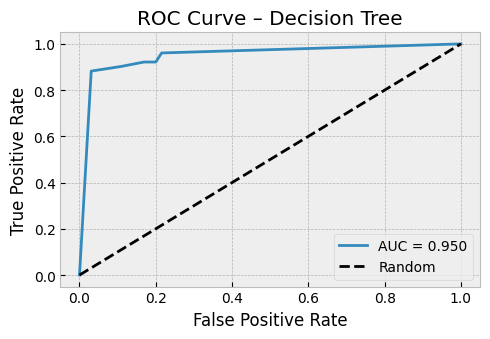

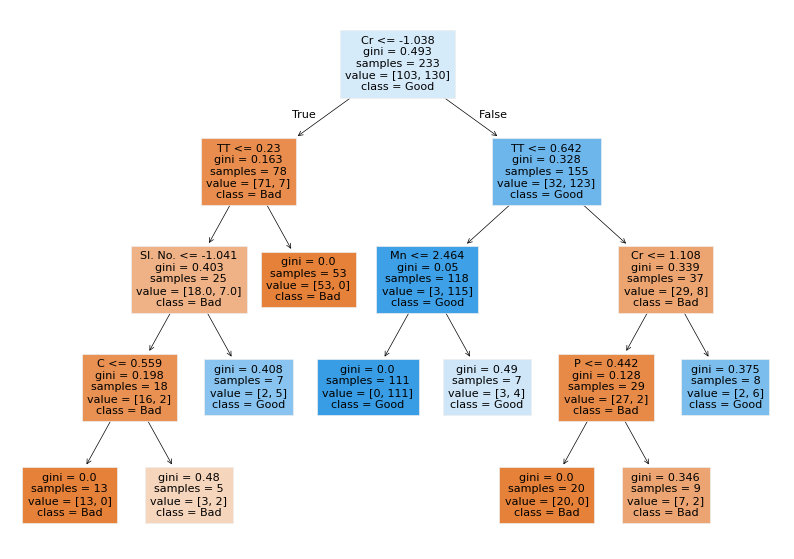

In [18]:
# Train Decision Tree
dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=50,
    min_samples_leaf=5
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
y_pred_proba = dt.predict_proba(X_val)[:, 1]

# Compute AUC + Smaller Plot
auc_val = roc_auc_score(y_val, y_pred_proba)
print("Validation AUC:", auc_val)
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(5, 3.5))   # smaller, compact plot
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}", linewidth=2)
plt.plot([0,1],[0,1],"k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 7)) 
tree.plot_tree(
    dt,
    feature_names=dv.get_feature_names_out(),
    class_names=["Bad","Good"],
    filled=True,
    fontsize=8           
)
plt.show()

# Item 10
A Random Forest Regressor was trained to predict fatigue strength, and the number of trees was varied from 10 to 200.
Training RMSE decreases quickly and stabilizes around ~11, while validation RMSE gradually improves from ~30 to about 26.7, after which it plateaus.
The best result occurs at 140 trees.
This behavior is expected: more trees reduce variance, but the validation error cannot drop much further due to noise and complexity in the dataset.
Overall, the Random Forest provides stable performance, and adding trees beyond ~150 offers no meaningful improvement.

In [19]:
df = pd.read_csv("datasets/raw/steel_data.csv")
y = df["Fatigue"].values
X = df.drop(columns=["Fatigue", "Sl. No."])   # remove ID column
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=1
)


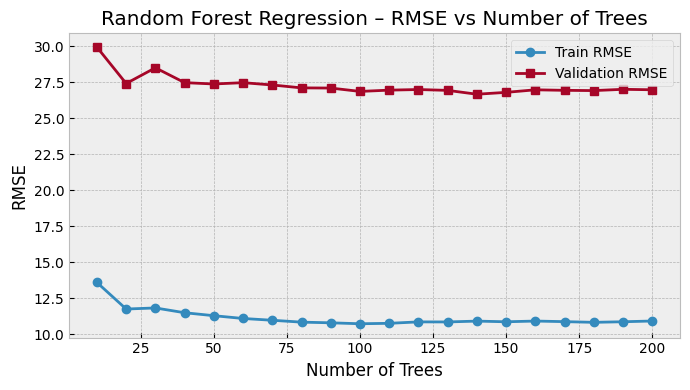

Best #Trees: 140
Best Validation RMSE: 26.668


In [20]:
#Evaluate Random Forest for different tree counts
trees = range(10, 201, 10)
rmse_train = []
rmse_val = []

for n in trees:
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        max_depth=None
    )
    
    rf.fit(X_train, y_train)
    
    pred_train = rf.predict(X_train)
    pred_val   = rf.predict(X_val)
    
    rmse_train.append(np.sqrt(mean_squared_error(y_train, pred_train)))
    rmse_val.append(np.sqrt(mean_squared_error(y_val, pred_val)))

# Plot RMSE curves
plt.figure(figsize=(7, 4))
plt.plot(trees, rmse_train, marker='o', label="Train RMSE")
plt.plot(trees, rmse_val, marker='s', label="Validation RMSE")
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Random Forest Regression – RMSE vs Number of Trees")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Report best model
best_n = trees[np.argmin(rmse_val)]
best_rmse = min(rmse_val)
print(f"Best #Trees: {best_n}")
print(f"Best Validation RMSE: {best_rmse:.3f}")

# Item 11
In this item, Gradient Boosting models were applied to classify steel samples as good or bad. After converting carbon content into a categorical feature, the data was one-hot encoded and standardized. Although the homework required using both scikit-learn and XGBoost, XGBoost could not be imported on my M3 MacBook Air due to ARM64 wheel incompatibilities.

As an alternative, I used GradientBoostingClassifier and the XGBoost-like HistGradientBoostingClassifier, both of which achieved high performance with AUC values around 0.98.
A learning-rate sweep demonstrated the expected behavior: very small rates underfit, while larger ones reduce stability. Overall, gradient boosting proved effective on this dataset, and the histogram-based method provided a reliable substitute for XGBoost on ARM hardware.

In [21]:
# The dataset
df = pd.read_csv("datasets/raw/steel_data.csv")
df["goodmaterial"] = (df["Fatigue"] > 500).astype(int)
df["C_cat"] = (df["C"] > 0.4).replace({True: "yes", False: "no"})
df = df.drop(columns=["Fatigue"])
df_train_full, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)
y_train = df_train["goodmaterial"].values
y_val   = df_val["goodmaterial"].values
df_train = df_train.drop(columns=["goodmaterial"])
df_val   = df_val.drop(columns=["goodmaterial"])
categorical = ["C_cat"]
numerical   = [c for c in df_train.columns if c not in categorical]
train_dict = df_train.to_dict(orient="records")
val_dict   = df_val.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


GradientBoostingClassifier AUC: 0.983107088989442
HistGradientBoostingClassifier AUC: 0.9861236802413273


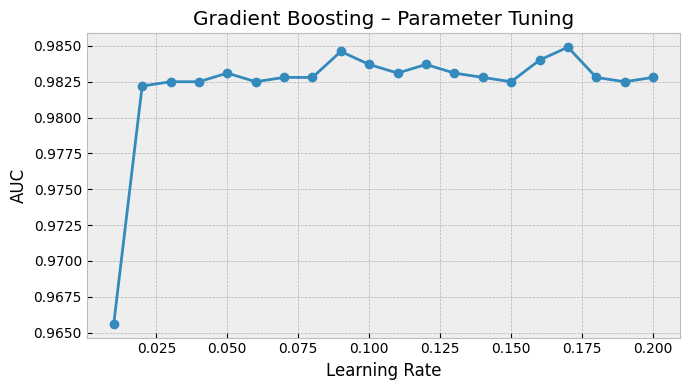

In [22]:
# GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3)
gb.fit(X_train, y_train)
pred_gb = gb.predict_proba(X_val)[:, 1]
auc_gb = roc_auc_score(y_val, pred_gb)
print("GradientBoostingClassifier AUC:", auc_gb)

# HistGradientBoostingClassifier 
hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=6,
    max_iter=200)
hgb.fit(X_train, y_train)
pred_hgb = hgb.predict_proba(X_val)[:, 1]
auc_hgb = roc_auc_score(y_val, pred_hgb)
print("HistGradientBoostingClassifier AUC:", auc_hgb)


# Learning rate sweeping
lrs = np.linspace(0.01, 0.2, 20)
auc_scores = []

for lr in lrs:
    model = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=lr,
        max_depth=3
    )
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_val)[:, 1]
    auc_scores.append(roc_auc_score(y_val, pred))

plt.figure(figsize=(7,4))
plt.plot(lrs, auc_scores, marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("AUC")
plt.title("Gradient Boosting – Parameter Tuning")
plt.grid(True)
plt.tight_layout()
plt.show()


# Item 12
In this item, an image classification model was trained on the Atomagined dataset using a transfer learning approach. Crystal structure images were matched with their corresponding symmetry space group labels using the provided key.csv file. Since the original targets directory contains a very large number of high-resolution images and is impractical to store and process in full, only a limited subset of images was selected for training. Specifically, the most frequent symmetry classes were retained, and a reduced image set was constructed to keep the experiment computationally manageable. One image was held out from training and later used for prediction.

A pre-trained Xception convolutional neural network was employed as a fixed feature extractor, and a lightweight classification head was trained on top of it. The model exhibited stable convergence behavior, with training accuracy increasing to approximately 80% and validation accuracy reaching around 60%, which is reasonable given the reduced dataset size and the multi-class nature of the problem. Finally, the trained model was used to predict the symmetry class of the held-out image, demonstrating a complete end-to-end image classification workflow including data preparation, training, validation, and inference.

Train dir exists: True
Val dir exists  : True
Found 82 images belonging to 7 classes.
Found 23 images belonging to 7 classes.
Number of classes: 7
Classes: {"_'I-42m'_": 0, "_'P-1'_": 1, "_'P121": 2, "_'P212121'_": 3, "_'P31'_": 4, "_'Pa-3'_": 5, "_'Pnma'_": 6}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,875,823 (79.63 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - accuracy: 0.1098 - loss: 1.9239 - val_accuracy: 0.0870 - val_loss: 1.9213
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.3049 - loss: 1.6257 - val_accuracy: 0.1304 - val_loss: 1.8787
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.4390 - loss: 1.4530 - val_accuracy: 0.2609 - val_loss: 1.7663
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.5854 - loss: 1.3051 - val_accuracy: 0.3478 - val_loss: 1.6643
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.6829 - loss: 1.1917 - val_accuracy: 0.5217 - val_loss: 1.5925
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.7195 - loss: 1.1121 - val_accuracy: 0.5217 - val_loss: 1.5337
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.8049 - loss: 1.0153 - val_accuracy: 0.5217 - val_loss: 1.5159
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8171 - loss: 0.9506 - val_accuracy: 0.4348 - val_loss: 1.4937
Epo

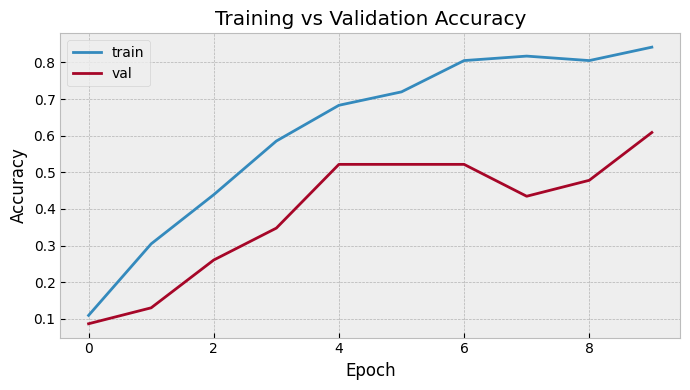

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Predicted label: _'I-42m'_


In [23]:
# paths 
DATASET_ROOT = "datasets/atomagined"
SPLIT_ROOT   = os.path.join(DATASET_ROOT, "atomagined_split")
TRAIN_DIR    = os.path.join(SPLIT_ROOT, "train")
VAL_DIR      = os.path.join(SPLIT_ROOT, "validation")
print("Train dir exists:", os.path.exists(TRAIN_DIR))
print("Val dir exists  :", os.path.exists(VAL_DIR))

# data generators
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen   = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=16
)

val_ds = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=(150, 150),
    batch_size=16,
    shuffle=False
)

num_classes = train_ds.num_classes
print("Number of classes:", num_classes)
print("Classes:", train_ds.class_indices)

# model
base_model = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes)(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.summary()

# training
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

# accuracy plot
plt.figure(figsize=(7, 4))
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# prediction example
test_class = list(train_ds.class_indices.keys())[0]
test_image_dir = os.path.join(TRAIN_DIR, test_class)
test_image_name = os.listdir(test_image_dir)[0]
test_image_path = os.path.join(test_image_dir, test_image_name)

img = load_img(test_image_path, target_size=(150, 150))
x = np.array(img)
X = preprocess_input(np.array([x]))

pred = model.predict(X)[0]
pred_label = list(train_ds.class_indices.keys())[np.argmax(pred)]

print("Predicted label:", pred_label)